# Importando módulos 

In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
import glidertools as gt

#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Inputs e Outputs

In [2]:
FOLDER_OUTPUT = '/home/dIOGOLOC/dados_posdoc/gliders_project/OUTPUT/'

FEATHER_OUTPUT = '/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/FEATHER/'


MSEED_INPUT = "/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/MSEED/"

# Extraindo informações dos arquivos ".mseed"

In [3]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*.mseed'))

In [4]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())


    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
        
    
    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[0].stats.endtime.datetime
    sampling_rate = st[0].stats.sampling_rate
    npts = st[0].stats.npts

    
    df = pd.DataFrame([[filename],[mergulho],[stream_number],[starttime],[endtime],[sampling_rate],[npts]], index=['filename_mseed', 'mergulho', 'stream_number','starttime','endtime','sampling_rate','npts']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [5]:
pandas_mseed_lst = []

with Pool(processes=8) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|██████████████████████████████████| 109315/109315 [06:52<00:00, 265.18it/s]


In [6]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)

In [7]:
dataframe_mseed_final.sort_values(by='starttime')

,filename_mseed,mergulho,stream_number,starttime,endtime,sampling_rate,npts
0,pa0001au_001_151112_134841,0001,001,2015-11-12 13:48:41,2015-11-12 13:50:40.930,100.0,11994
1,pa0001au_002_151112_135041,0001,002,2015-11-12 13:50:41,2015-11-12 13:52:40.930,100.0,11994
19,pa0001au_003_151112_135241,0001,003,2015-11-12 13:52:41,2015-11-12 13:54:40.930,100.0,11994
2,pa0001au_004_151112_135441,0001,004,2015-11-12 13:54:41,2015-11-12 13:56:40.930,100.0,11994
6,pa0001au_005_151112_135641,0001,005,2015-11-12 13:56:41,2015-11-12 13:57:00.980,100.0,1999
...,...,...,...,...,...,...,...
109304,pa0238au_013_191010_211037,0238,013,2019-10-10 21:10:37,2019-10-10 21:20:36.990,100.0,60000
109306,pa0238au_014_191010_212037,0238,014,2019-10-10 21:20:37,2019-10-10 21:30:36.990,100.0,60000
109307,pa0238au_015_191010_213037,0238,015,2019-10-10 21:30:37,2019-10-10 21:40:36.990,100.0,60000
109309,pa0238au_016_191010_214037,0238,016,2019-10-10 21:40:37,2019-10-10 21:50:36.990,100.0,60000


In [8]:
dataframe_mseed_final['duration'] = (dataframe_mseed_final['endtime'] - dataframe_mseed_final['starttime']).dt.total_seconds() / 60

In [9]:
dataframe_mseed_final.sort_values(by='starttime')

,filename_mseed,mergulho,stream_number,starttime,endtime,sampling_rate,npts,duration
0,pa0001au_001_151112_134841,0001,001,2015-11-12 13:48:41,2015-11-12 13:50:40.930,100.0,11994,1.998833
1,pa0001au_002_151112_135041,0001,002,2015-11-12 13:50:41,2015-11-12 13:52:40.930,100.0,11994,1.998833
19,pa0001au_003_151112_135241,0001,003,2015-11-12 13:52:41,2015-11-12 13:54:40.930,100.0,11994,1.998833
2,pa0001au_004_151112_135441,0001,004,2015-11-12 13:54:41,2015-11-12 13:56:40.930,100.0,11994,1.998833
6,pa0001au_005_151112_135641,0001,005,2015-11-12 13:56:41,2015-11-12 13:57:00.980,100.0,1999,0.333000
...,...,...,...,...,...,...,...,...
109304,pa0238au_013_191010_211037,0238,013,2019-10-10 21:10:37,2019-10-10 21:20:36.990,100.0,60000,9.999833
109306,pa0238au_014_191010_212037,0238,014,2019-10-10 21:20:37,2019-10-10 21:30:36.990,100.0,60000,9.999833
109307,pa0238au_015_191010_213037,0238,015,2019-10-10 21:30:37,2019-10-10 21:40:36.990,100.0,60000,9.999833
109309,pa0238au_016_191010_214037,0238,016,2019-10-10 21:40:37,2019-10-10 21:50:36.990,100.0,60000,9.999833


In [10]:
dataframe_mseed_final_duration = dataframe_mseed_final.groupby("stream_number")['duration'].mean()

In [11]:
dataframe_mseed_final_duration_max = dataframe_mseed_final.groupby("stream_number")['duration'].max()

In [12]:
dataframe_mseed_final_duration_max

stream_number
001    9.999833
002    9.999833
003    9.999833
004    9.999833
005    9.999833
         ...   
120    2.988333
121    2.988333
122    2.988333
123    2.988333
124    2.988333
Name: duration, Length: 124, dtype: float64

In [13]:
dataframe_mseed_final

,filename_mseed,mergulho,stream_number,starttime,endtime,sampling_rate,npts,duration
0,pa0001au_001_151112_134841,0001,001,2015-11-12 13:48:41,2015-11-12 13:50:40.930,100.0,11994,1.998833
1,pa0001au_002_151112_135041,0001,002,2015-11-12 13:50:41,2015-11-12 13:52:40.930,100.0,11994,1.998833
2,pa0001au_004_151112_135441,0001,004,2015-11-12 13:54:41,2015-11-12 13:56:40.930,100.0,11994,1.998833
3,pa0002au_001_151112_143618,0002,001,2015-11-12 14:36:18,2015-11-12 14:38:17.930,100.0,11994,1.998833
4,pa0002au_004_151112_144218,0002,004,2015-11-12 14:42:18,2015-11-12 14:44:17.930,100.0,11994,1.998833
...,...,...,...,...,...,...,...,...
109310,pa0238au_009_191010_203036,0238,009,2019-10-10 20:30:36,2019-10-10 20:40:35.990,100.0,60000,9.999833
109311,pa0238au_017_191010_215037,0238,017,2019-10-10 21:50:37,2019-10-10 21:59:05.130,100.0,50814,8.468833
109312,pa0238au_008_191010_202036,0238,008,2019-10-10 20:20:36,2019-10-10 20:30:35.990,100.0,60000,9.999833
109313,pa0238au_012_191010_210037,0238,012,2019-10-10 21:00:37,2019-10-10 21:10:36.990,100.0,60000,9.999833


In [14]:
ano_lst = sorted(list(set(dataframe_mseed_final['starttime'].dt.year)))
ano_lst

[2015, 2016, 2017, 2018, 2019]

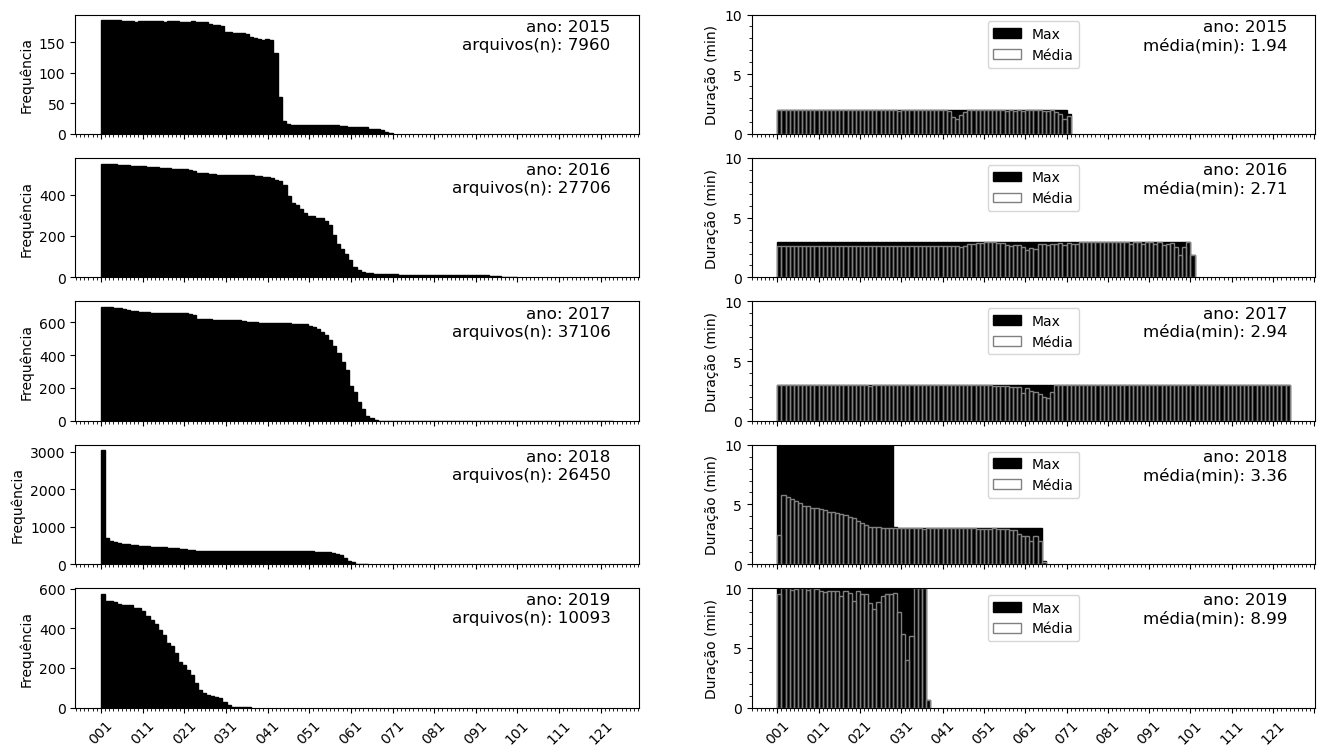

In [15]:
fig, axes = plt.subplots(len(ano_lst),2,sharex='col',figsize=(16,9))

for i,j in enumerate(ano_lst):
    ax = axes[i][0]
    ax1 = axes[i][1]
    # ------
    # Stream
    # ------
    dataframe_mseed_final_year = dataframe_mseed_final[dataframe_mseed_final['starttime'].dt.year == j]

    dataframe_mseed_final_duration = dataframe_mseed_final_year.groupby("stream_number")['duration'].mean()
    dataframe_mseed_final_duration_max = dataframe_mseed_final_year.groupby("stream_number")['duration'].max()
    
    # Plotar o histograma da coluna
    ax.hist(sorted(dataframe_mseed_final_year['stream_number']), bins=len(dataframe_mseed_final_year['stream_number'].unique())*1, ec='k',fc='k')

    # Configurar o título e rótulos dos eixos
    ax.set_ylabel('Frequência')
    
    ax.text(0.95, 0.9, 'ano: '+str(j), fontsize=12, ha='right', va='center', transform=ax.transAxes)
    ax.text(0.95, 0.75, 'arquivos(n): '+str(len(dataframe_mseed_final_year)), fontsize=12, ha='right', va='center', transform=ax.transAxes)

    # Set major xticks
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.tick_params(axis='x', rotation=45)

    # Set minor xticks
    ax.xaxis.set_minor_locator(MultipleLocator(1))


    # --------
    # Duration
    # --------

    # Plotar o histograma da coluna
    ax1.bar(x=dataframe_mseed_final_duration_max.index.values,height=dataframe_mseed_final_duration_max.values,align='edge',width=1,alpha=1,ec='k',fc='k',label='Max')
    ax1.bar(x=dataframe_mseed_final_duration.index.values,height=dataframe_mseed_final_duration.values,align='edge',width=1,alpha=1,ec='gray',fc='none',label='Média')

    # Configurar o título e rótulos dos eixos
    ax1.set_ylabel('Duração (min)')
    ax1.set_ylim(0,10)
    
    ax1.text(0.95, 0.9, 'ano: '+str(j), fontsize=12, ha='right', va='center', transform=ax1.transAxes)
    ax1.text(0.95, 0.75, 'média(min): '+str(round(dataframe_mseed_final_duration.values.mean(),2)), fontsize=12, ha='right', va='center', transform=ax1.transAxes)

    # Set major ticks
    ax1.xaxis.set_major_locator(MultipleLocator(10))
    ax1.yaxis.set_major_locator(MultipleLocator(5))
    ax1.tick_params(axis='x', rotation=45)

    # Set minor ticks
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_minor_locator(MultipleLocator(1))

    # Add a legend to the plot
    ax1.legend(loc='upper center')
    
    # -----
    
    if i == len(axes):
        ax.set_xlabel('Stream (nº)')
        ax1.set_xlabel('Stream (nº)')

# Extraindo informações dos arquivos ".csv"

In [16]:
filename_csv = '/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/metadados_glider_acustico_pmpas-bs.csv'

In [17]:
dataframe_csv = pd.read_csv(filename_csv,parse_dates=['time'])
dataframe_csv.sort_values(by='time')

,time,filename,latitude,longitude,depth
0,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841_rms_spl3.mat,-23.825157,-42.495483,1.314286
1,2015-11-12 13:49:41.000001,pa0001au_001_151112_134841_rms_spl3.mat,-23.824950,-42.495487,7.415555
2,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041_rms_spl3.mat,-23.824745,-42.495490,15.776000
3,2015-11-12 13:51:41.000004,pa0001au_002_151112_135041_rms_spl3.mat,-23.824540,-42.495495,24.372000
4,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241_rms_spl3.mat,-23.824331,-42.495500,32.912000
...,...,...,...,...,...
547748,2021-11-04 06:52:38.000000,pa0296au_011_211104_064338_rms_spl3.mat,-24.461742,-42.471264,866.012900
547749,2021-11-04 06:53:37.999997,pa0296au_012_211104_065338_rms_spl3.mat,-24.461819,-42.471302,873.586100
547750,2021-11-04 06:54:38.000003,pa0296au_012_211104_065338_rms_spl3.mat,-24.461980,-42.471510,879.579600
547751,2021-11-04 06:55:38.000000,pa0296au_012_211104_065338_rms_spl3.mat,-24.462152,-42.471740,884.380700


In [18]:
df_csv = dataframe_csv.groupby("filename").agg(pd.Series.tolist)

In [19]:
df_csv

,time,latitude,longitude,depth
filename,,,,
160708_172008_pa0003au_001_rms_spl3.mat,"[2016-07-08 17:20:07.999999, 2016-07-08 17:21:...","[-24.391026, -24.391314, -24.391335]","[-43.821663, -43.82173, -43.82174]","[0.9987981, 9.891874, 10.969999]"
160708_172307_pa0003au_002_rms_spl3.mat,"[2016-07-08 17:23:07.000004, 2016-07-08 17:24:...","[-24.391356, -24.3916, -24.391617]","[-43.821743, -43.8218, -43.821804]","[12.030156, 23.590548, 24.420235]"
160708_172607_pa0003au_003_rms_spl3.mat,"[2016-07-08 17:26:07.000003, 2016-07-08 17:27:...","[-24.391909, -24.39193, -24.392172]","[-43.821873, -43.82188, -43.821938]","[36.456642, 37.333202, 47.245785]"
160708_172906_pa0003au_004_rms_spl3.mat,"[2016-07-08 17:29:05.999998, 2016-07-08 17:30:...","[-24.392193, -24.392475, -24.392496]","[-43.82194, -43.822006, -43.82201]","[48.01094, 58.52969, 59.289062]"
160708_173205_pa0003au_005_rms_spl3.mat,"[2016-07-08 17:32:05.000003, 2016-07-08 17:33:...","[-24.392744, -24.392765, -24.393057]","[-43.822067, -43.822075, -43.822144]","[68.57156, 69.49031, 80.89149]"
...,...,...,...,...
pa0626au_041_160418_075202_rms_spl3.mat,"[2016-04-18 07:52:02.000001, 2016-04-18 07:53:...","[-24.46632, -24.466305]","[-43.148865, -43.14886]","[897.4117, 899.9383]"
pa0626au_042_160418_075402_rms_spl3.mat,"[2016-04-18 07:54:02.000004, 2016-04-18 07:55:02]","[-24.466183, -24.466167]","[-43.14885, -43.148846]","[918.85736, 921.4589]"
pa0626au_043_160418_075602_rms_spl3.mat,"[2016-04-18 07:56:01.999997, 2016-04-18 07:57:...","[-24.466047, -24.466032]","[-43.148834, -43.14883]","[940.0661, 942.0864]"


In [20]:
df_csv['filename_mseed'] = df_csv.index.str.replace('_rms_spl3.mat', '')

/tmp/ipykernel_12666/1878750020.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_csv['filename_mseed'] = df_csv.index.str.replace('_rms_spl3.mat', '')


In [21]:
df_csv.sort_values(by='time')

,time,latitude,longitude,depth,filename_mseed
filename,,,,,
pa0001au_001_151112_134841_rms_spl3.mat,"[2015-11-12 13:48:40.999995, 2015-11-12 13:49:...","[-23.825157, -23.82495]","[-42.495483, -42.495487]","[1.3142858, 7.4155555]",pa0001au_001_151112_134841
pa0001au_002_151112_135041_rms_spl3.mat,"[2015-11-12 13:50:40.999998, 2015-11-12 13:51:...","[-23.824745, -23.82454]","[-42.49549, -42.495495]","[15.776, 24.372]",pa0001au_002_151112_135041
pa0001au_003_151112_135241_rms_spl3.mat,"[2015-11-12 13:52:41.000001, 2015-11-12 13:53:...","[-23.824331, -23.824125]","[-42.4955, -42.495502]","[32.912, 41.34]",pa0001au_003_151112_135241
pa0001au_004_151112_135441_rms_spl3.mat,"[2015-11-12 13:54:41.000004, 2015-11-12 13:55:41]","[-23.82392, -23.823713]","[-42.495506, -42.495506]","[48.91, 52.824]",pa0001au_004_151112_135441
pa0002au_001_151112_143618_rms_spl3.mat,"[2015-11-12 14:36:17.999998, 2015-11-12 14:37:...","[-23.817575, -23.81744]","[-42.49506, -42.494965]","[1.4671428, 9.36]",pa0002au_001_151112_143618
...,...,...,...,...,...
pa0296au_008_211104_061338_rms_spl3.mat,"[2021-11-04 06:13:37.999999, 2021-11-04 06:14:...","[-24.457632, -24.457657, -24.457726, -24.45786...","[-42.470257, -42.470303, -42.470325, -42.47033...","[550.4096, 559.3073, 567.8462, 575.10706, 582....",pa0296au_008_211104_061338
pa0296au_009_211104_062338_rms_spl3.mat,"[2021-11-04 06:23:38.000003, 2021-11-04 06:24:...","[-24.458628, -24.458672, -24.45872, -24.458822...","[-42.47047, -42.470528, -42.470562, -42.470573...","[629.96436, 637.68353, 646.56323, 654.6224, 66...",pa0296au_009_211104_062338
pa0296au_010_211104_063338_rms_spl3.mat,"[2021-11-04 06:33:37.999998, 2021-11-04 06:34:...","[-24.459415, -24.459513, -24.45957, -24.45963,...","[-42.4708, -42.470802, -42.470856, -42.4709, -...","[706.7263, 715.5506, 722.5956, 730.11316, 737....",pa0296au_010_211104_063338


# Aglutinando os dataframes: 

In [22]:
merged_df_csv_mseed = df_csv.merge(dataframe_mseed_final, on='filename_mseed')

In [23]:
merged_df_csv_mseed['time_timestamp'] = merged_df_csv_mseed['time'].apply(lambda x: [pd.to_datetime(date).timestamp() for date in x])

In [24]:
merged_df_csv_mseed.sort_values(by='starttime')

,time,latitude,longitude,depth,filename_mseed,mergulho,stream_number,starttime,endtime,sampling_rate,npts,duration,time_timestamp
76390,"[2015-11-12 13:48:40.999995, 2015-11-12 13:49:...","[-23.825157, -23.82495]","[-42.495483, -42.495487]","[1.3142858, 7.4155555]",pa0001au_001_151112_134841,0001,001,2015-11-12 13:48:41,2015-11-12 13:50:40.930,100.0,11994,1.998833,"[1447336120.999995, 1447336181.000001]"
76394,"[2015-11-12 13:50:40.999998, 2015-11-12 13:51:...","[-23.824745, -23.82454]","[-42.49549, -42.495495]","[15.776, 24.372]",pa0001au_002_151112_135041,0001,002,2015-11-12 13:50:41,2015-11-12 13:52:40.930,100.0,11994,1.998833,"[1447336240.999998, 1447336301.000004]"
76398,"[2015-11-12 13:52:41.000001, 2015-11-12 13:53:...","[-23.824331, -23.824125]","[-42.4955, -42.495502]","[32.912, 41.34]",pa0001au_003_151112_135241,0001,003,2015-11-12 13:52:41,2015-11-12 13:54:40.930,100.0,11994,1.998833,"[1447336361.000001, 1447336420.999997]"
76402,"[2015-11-12 13:54:41.000004, 2015-11-12 13:55:41]","[-23.82392, -23.823713]","[-42.495506, -42.495506]","[48.91, 52.824]",pa0001au_004_151112_135441,0001,004,2015-11-12 13:54:41,2015-11-12 13:56:40.930,100.0,11994,1.998833,"[1447336481.000004, 1447336541.0]"
76428,"[2015-11-12 14:36:17.999998, 2015-11-12 14:37:...","[-23.817575, -23.81744]","[-42.49506, -42.494965]","[1.4671428, 9.36]",pa0002au_001_151112_143618,0002,001,2015-11-12 14:36:18,2015-11-12 14:38:17.930,100.0,11994,1.998833,"[1447338977.999998, 1447339038.000005]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96568,"[2019-10-10 21:10:37.000005, 2019-10-10 21:11:...","[-24.700645, -24.700645, -24.700645, -24.70064...","[-41.329514, -41.329514, -41.329514, -41.32951...","[810.5255, 810.5255, 810.5255, 810.5255, 810.5...",pa0238au_013_191010_211037,0238,013,2019-10-10 21:10:37,2019-10-10 21:20:36.990,100.0,60000,9.999833,"[1570741837.000005, 1570741897.000001, 1570741..."
96570,"[2019-10-10 21:20:36.999999, 2019-10-10 21:21:...","[-24.700645, -24.700645, -24.700645, -24.70064...","[-41.329514, -41.329514, -41.329514, -41.32951...","[810.5255, 810.5255, 810.5255, 810.5255, 810.5...",pa0238au_014_191010_212037,0238,014,2019-10-10 21:20:37,2019-10-10 21:30:36.990,100.0,60000,9.999833,"[1570742436.999999, 1570742496.999996, 1570742..."
96572,"[2019-10-10 21:30:37.000004, 2019-10-10 21:31:...","[-24.700645, -24.700645, -24.700645, -24.70064...","[-41.329514, -41.329514, -41.329514, -41.32951...","[810.5255, 810.5255, 810.5255, 810.5255, 810.5...",pa0238au_015_191010_213037,0238,015,2019-10-10 21:30:37,2019-10-10 21:40:36.990,100.0,60000,9.999833,"[1570743037.000004, 1570743097.0, 1570743156.9..."
96574,"[2019-10-10 21:40:36.999998, 2019-10-10 21:41:...","[-24.700645, -24.700645, -24.700645, -24.70064...","[-41.329514, -41.329514, -41.329514, -41.32951...","[810.5255, 810.5255, 810.5255, 810.5255, 810.5...",pa0238au_016_191010_214037,0238,016,2019-10-10 21:40:37,2019-10-10 21:50:36.990,100.0,60000,9.999833,"[1570743636.999998, 1570743697.000005, 1570743..."


# Interpolando os dados de profundidade, latitude, longitude em função da série temporal através do numpy interp:

One-dimensional linear interpolation for monotonically increasing sample points.

Returns the one-dimensional piecewise linear interpolant to a function
with given discrete data points (`xp`, `fp`), evaluated at `x`.

Parameters
----------
x : array_like
    The x-coordinates at which to evaluate the interpolated values.

xp : 1-D sequence of floats
    The x-coordinates of the data points, must be increasing if argument
    `period` is not specified. Otherwise, `xp` is internally sorted after
    normalizing the periodic boundaries with ``xp = xp % period``.

fp : 1-D sequence of float or complex
    The y-coordinates of the data points, same length as `xp`.

left : optional float or complex corresponding to fp
    Value to return for `x < xp[0]`, default is `fp[0]`.

right : optional float or complex corresponding to fp
    Value to return for `x > xp[-1]`, default is `fp[-1]`.

period : None or float, optional
    A period for the x-coordinates. This parameter allows the proper
    interpolation of angular x-coordinates. Parameters `left` and `right`
    are ignored if `period` is specified.

    .. versionadded:: 1.10.0

Returns
-------
y : float or complex (corresponding to fp) or ndarray
    The interpolated values, same shape as `x`.

In [25]:
def interp_dataframe_depth_lat_lon_time(filename_mseed,df=merged_df_csv_mseed,filenames_MSEED_lst=filenames_MSEED):
    new_df = df[df['filename_mseed'] == filename_mseed]
    # Dados de profundidade, latitude, longitude e tempo numérico
    profundidade = new_df['depth'].values[0]
    latitude = new_df['latitude'].values[0]
    longitude = new_df['longitude'].values[0]
    tempo_numerico = new_df['time_timestamp'].values[0]

    # Importar array de tempo interpolado
    for i in filenames_MSEED_lst:
        if filename_mseed in i:
            st = read(i,headonly=True)   
            tempo_interpolado_numerico = st[0].times('timestamp')
            tempo_interpolado = [k.datetime for k in st[0].times("utcdatetime")]
            tempo_obspy_times = st[0].times()

    # Interpolar os dados de profundidade usando numpy.interp
    profundidade_interpolada = np.interp(tempo_interpolado_numerico, tempo_numerico, profundidade)

    # Interpolar os dados de latitude usando numpy.interp
    latitude_interpolada = np.interp(tempo_interpolado_numerico, tempo_numerico, latitude)

    # Interpolar os dados de longitude usando numpy.interp
    longitude_interpolada = np.interp(tempo_interpolado_numerico, tempo_numerico, longitude)

    # Salvar os resultados
    df_interpolado = pd.DataFrame({'filename_mseed':filename_mseed+'.mseed',
                                   'Time_interp': tempo_interpolado, 
                                   'depth_interp': profundidade_interpolada, 
                                   'latitude_interp': latitude_interpolada, 
                                   'longitude_interp': longitude_interpolada})
    
    # Salvar o DataFrame em um arquivo Feather
    year = st[0].times("utcdatetime")[0].strftime('%Y')
    pasta_dia = st[0].times("utcdatetime")[0].strftime('%Y-%m-%d')
    output_folder_feather = FEATHER_OUTPUT+'/'+year+'/'+pasta_dia+'/'
    os.makedirs(output_folder_feather,exist_ok=True)
    df_interpolado.to_feather(output_folder_feather+filename_mseed+'.feather')

In [26]:
with Pool(processes=4) as p:
    max_ = len(merged_df_csv_mseed['filename_mseed'])
    with tqdm(total=max_) as pbar:
        for _ in p.imap_unordered(interp_dataframe_depth_lat_lon_time,merged_df_csv_mseed['filename_mseed']):
            pbar.update()

100%|█████████████████████████████████| 105399/105399 [4:40:42<00:00,  6.26it/s]
